# Lotka-Volterra Model with Multiplicative Noise

## Model Definition

The SDE is given by $\XX_t = (U_t, V_t)$

$$
\begin{bmatrix}
\ud U_t \\
\ud V_t
\end{bmatrix}
= 
\begin{bmatrix} 
\alpha U_t - \beta U_t V_t \\ 
\beta U_t V_t - \gamma V_t 
\end{bmatrix} \ud t + 
\begin{bmatrix}
\alpha U_t + \beta U_t V_t & - \beta U_t V_t \\
-\beta U_t V_t & \gamma V_t + \beta U_t V_t
\end{bmatrix}^{1/2} \ud \BB_t.
$$

However, the SDE is actually approximated on the log scale, $\ZZ_t = \log \XX_t$.  The noisy observations are given by 

$$
\yy_n \ind \N(\exp(\ZZ_n), \diag(\tta^2)).
$$

## Inference Settings

- In each case, please try to estimate $\pph = (\alpha, \beta, \gamma)$, assuming that $\tta$ is known.  

- Please do this with stochastic optimization, and make sure you provide a hessian estimate for the variance at the end.  

- You should use the "Bayesian normal approximation", which plots normal distributions with mean MLE and variance taken from the diagonal of the inverse Hessian.  Then put a vertical line for the true parameter value, as in the Ryder paper Figure 3.

- Make sure you do both the optimization/hessian/etc on $\log \pph$.  You are welcome to rewrite the `LVMultModel` below with $\tth = (\log \pph, \log \tta)$ as opposed to $\tth = (\pph, \tta)$.

### Setting 1

The following settings are modified from Ryder et al (2018), Section 5.1:


- $\pph = (\alpha, \beta, \gamma) = (0.5, 0.0025, 0.3)$.

- $\tta = (1, 1)$.

- $\XX_0 = (71, 79)$.

- `dt = 1`.

- `n_res = 10`.

- `n_obs = 50`.

### Setting 2

**Update:** Ignore this for now.

- Same as above, but $V_t$ is unobserved.  The easiest way to do this is to do the optimization/hessian/etc over $\pph$ while fixing $\tau = (1, 100)$.  So, the first $\tau$ is its true value, but the second $\tau$ is made so large that the corresponding observations provide no information about $\pph$.

- So, you simulate data with $\pph = \pph_{\text{true}}$ and $\tta = \tta_{\text{true}}$.  But for inference, you only optimize/hessian over $\pph$, as in setting 1, but now you change the fixed parameters to $\tta = (1, 100)$.



In [1]:
import jax
import jax.numpy as jnp
import jax.scipy as jsp
from jax import random
from jax import lax
import pfjax as pf
from pfjax import sde as sde

key = random.PRNGKey(0)


class LVMultModel(sde.SDEModel):
    def __init__(self, dt, n_res, bootstrap=False):
        self._dt = dt
        self._n_res = n_res
        self._n_state = (self._n_res, 2)
        self._bootstrap = bootstrap
        super().__init__(dt, n_res, diff_diag=False)

    def _get_params(self, theta):
        return theta[0], theta[1], theta[2], theta[3:4]

    def get_params(self, theta):
        return self._get_params(theta)

    def _get_data(self, x):
        return x[0], x[1]

    def _drift(self, x, theta):
        """Drift on the original scale."""
        alpha, beta, gamma, tau = self._get_params(theta)
        U, V = self._get_data(x)
        aU = alpha * U
        bUV = beta * U * V
        gV = gamma * V
        return jnp.array([aU - bUV, bUV - gV])

    def _diff(self, x, theta):
        """Drift on the original scale."""
        alpha, beta, gamma, tau = self._get_params(theta)
        U, V = self._get_data(x)
        aU = alpha * U
        bUV = beta * U * V
        gV = gamma * V
        return jnp.array([[aU + bUV, -bUV], [-bUV, gV + bUV]])

    def _ito_inv(self, x):
        """
        Inverse Ito transformation.

        In this case the transformation is `log(x)`, so the inverse transformation is `exp(x)`.
        """
        return jnp.exp(x)

    def _ito_dx(self, x):
        """
        Derivative of Ito transformation.

        If the transformation is `log(x)`, the derivative is `1/x`.
        """
        return 1.0/x

    def _ito_dx2(self, x):
        """
        Second derivative of Ito transformation.

        If the transformation is `log(x)`, the second derivative is `-1/x^2`.
        """
        return -1.0 / (x * x)

    def drift(self, x, theta):
        """
        Drift upon applying Ito transformation.
        """
        z = self._ito_inv(x)  # transform to original scale
        dx = self._ito_dx(z)
        dx2 = self._ito_dx2(z)
        return dx * self._drift(z, theta) + \
            0.5 * dx2 * jnp.diag(self._diff(z, theta))

    def diff(self, x, theta):
        """
        Diffusion upon applying Ito transformation.
        """
        z = self._ito_inv(x)  # transform to original scale
        dx = self._ito_dx(z)
        return jnp.outer(dx, dx) * self._diff(z, theta)

    def meas_lpdf(self, y_curr, x_curr, theta):
        r"""
        Log-density of `p(y_curr | x_curr, theta)`.

        FIXME: Explain the choice of distribution here.

        Args:
            y_curr: Measurement variable at current time `t`.
            x_curr: State variable at current time `t`.
            theta: Parameter value.

        Returns
            The log-density of `p(y_curr | x_curr, theta)`.
        """
        (alpha, beta, gamma, tau) = self._get_params(theta)
        return jnp.sum(
            jsp.stats.norm.logpdf(y_curr,
                                  loc=jnp.exp(x_curr[-1]), scale=tau)
        )

    def meas_sample(self, key, x_curr, theta):
        r"""
        Sample from `p(y_curr | x_curr, theta)`.

        Args:
            key: PRNG key.
            x_curr: State variable at current time `t`.
            theta: Parameter value.

        Returns:
            Sample of the measurement variable at current time `t`: `y_curr ~ p(y_curr | x_curr, theta)`.
        """
        (alpha, beta, gamma, tau) = self._get_params(theta)
        return jnp.exp(x_curr[-1]) + \
            tau * random.normal(key, (self._n_state[1],))

    def pf_init(self, key, y_init, theta):
        r"""
        Importance sampler for `x_init`.  

        See file comments for exact sampling distribution of `p(x_init | y_init, theta)`, i.e., we have a "perfect" importance sampler with `logw = CONST(theta)`.

        Args:
            key: PRNG key.
            y_init: Measurement variable at initial time `t = 0`.
            theta: Parameter value.

        Returns:
            - x_init: A sample from the proposal distribution for `x_init`.
            - logw: The log-weight of `x_init`.
        """
        (alpha, beta, gamma, tau) = self._get_params(theta)
        key, subkey = random.split(key)
        x_init = jnp.log(y_init + tau * random.truncated_normal(
            subkey,
            lower=-y_init/tau,
            upper=jnp.inf,
            shape=(self._n_state[1],)
        ))
        logw = jnp.sum(jsp.stats.norm.logcdf(y_init/tau))
        return \
            jnp.append(jnp.zeros((self._n_res-1,) + x_init.shape),
                       jnp.expand_dims(x_init, axis=0), axis=0), \
            logw

    def pf_step(self, key, x_prev, y_curr, theta):
        """
        Choose between bootstrap filter and bridge proposal.

        Args:
            x_prev: State variable at previous time `t-1`.
            y_curr: Measurement variable at current time `t`.
            theta: Parameter value.
            key: PRNG key.

        Returns:
            - x_curr: Sample of the state variable at current time `t`: `x_curr ~ q(x_curr)`.
            - logw: The log-weight of `x_curr`.
        """
        if self._bootstrap:
            x_curr, logw = super().pf_step(key, x_prev, y_curr, theta)
        else:
            (alpha, beta, gamma, tau) = self.get_params(theta)
            omega = (tau / y_curr)**2
            x_curr, logw = self.bridge_prop(
                key=key,
                x_prev=x_prev,
                y_curr=y_curr,
                theta=theta,
                Y=jnp.log(y_curr),
                A=jnp.eye(self._n_state[1]),
                Omega=jnp.diag(omega)
            )
        return x_curr, logw

In [2]:
# Simulate data from setting 1

theta = jnp.array([.5, .0025, .3, 1., 1.])
x0 = jnp.log(jnp.array([71., 79.]))

dt = 1.
n_res = 10
n_obs = 50

key, subkey = random.split(key)

x_init = jnp.block([[jnp.zeros((n_res-1, 2))], [x0]])
lv_model = LVMultModel(dt=dt, n_res=n_res)
(y_meas, x_state) = pf.simulate(
    model=lv_model,
    key=subkey,
    n_obs=n_obs,
    x_init=x_init,
    theta=theta
)

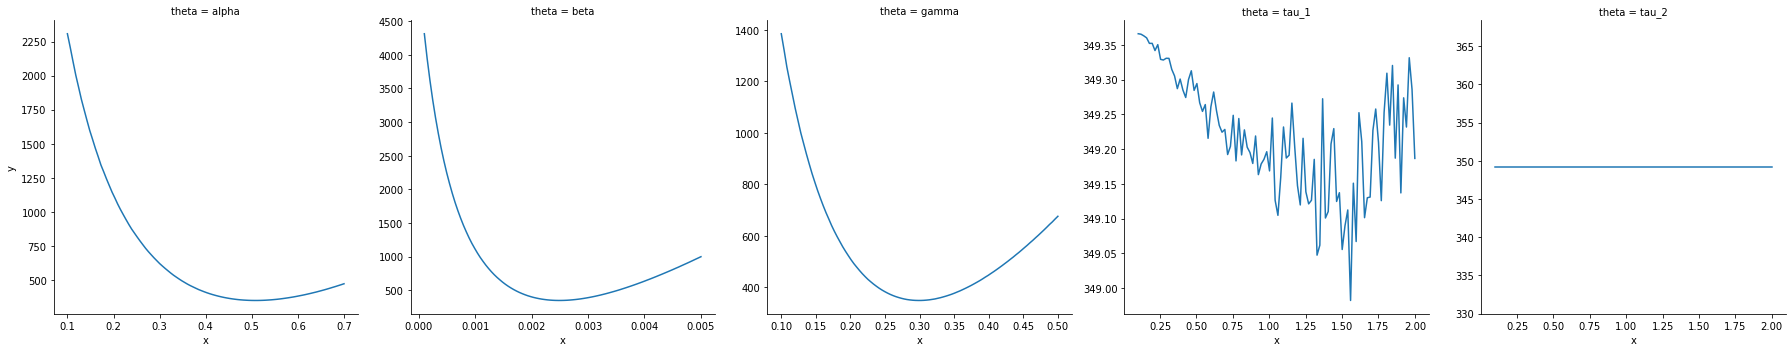

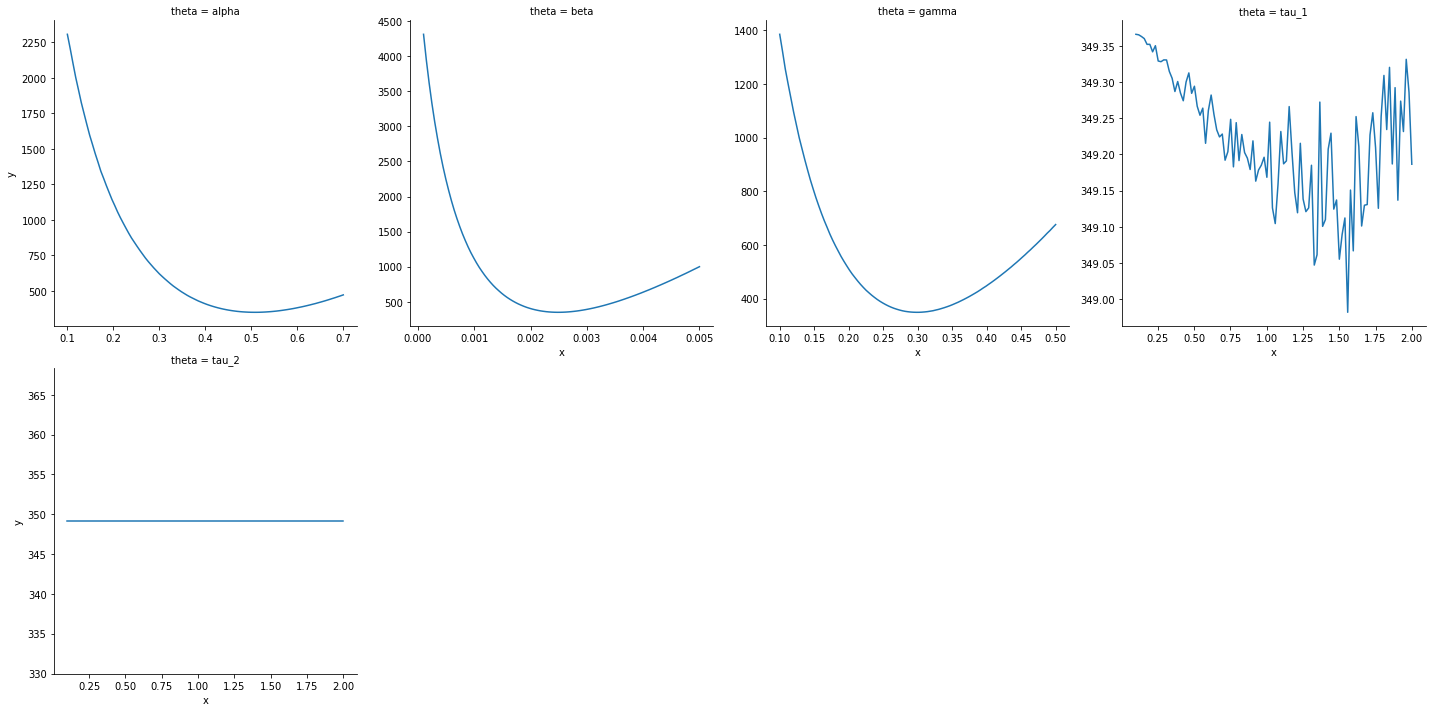

In [3]:
import numpy as np
import seaborn as sns
import projplot as pjp
theta_lims = np.array([[0.1, 0.7], [0.0001, 0.005], [0.1, 0.5], [0.1, 2.0], [0.1, 2.0]])
theta_names = ["alpha", "beta", "gamma", "tau_1", "tau_2"]
n_pts = 100

# calculate projection plot
n_particles = 1000

def proj_data(fun, x, x_lims, x_names, n_pts=100):
    """
    Wrapper for projxvals and projdata.
    """
    xvals = pjp.projxvals(x, x_lims, n_pts)
    return pjp.projdata(fun, xvals, x_names, is_vectorized=False)


@jax.jit
def lotvol_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=lv_model, y_meas=y_meas,
                              n_particles=n_particles, key=key)
    return -pf.particle_loglik(temp['logw'])


plot_df = proj_data(lotvol_pflik,
                    theta, theta_lims, theta_names)



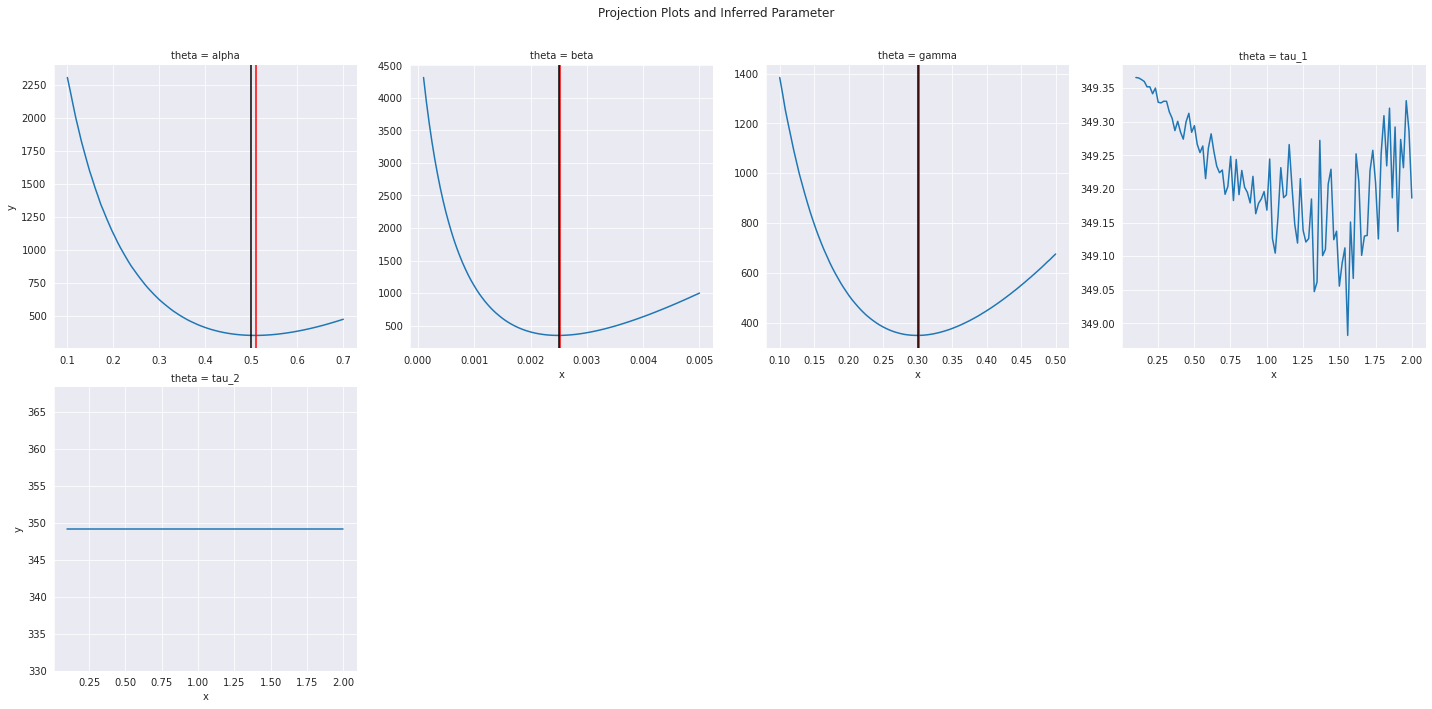

In [17]:
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
rp = sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 4,
    facet_kws=dict(sharex=False, sharey=False)
)

rp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
rp.fig.suptitle('Projection Plots and Inferred Parameter')

rp.axes[0].axvline(params_orig[0], color='red', label=r"\hat{\alpha}")
rp.axes[1].axvline(params_orig[1], color='red', label="\hat{\beta}")
rp.axes[2].axvline(params_orig[2], color='red', label="\hat{\gamma}")
rp.axes[0].axvline(theta[0], color='black', label="alpha")
rp.axes[1].axvline(theta[1], color='black', label="beta")
rp.axes[2].axvline(theta[2], color='black', label="gamma")


In [7]:
import optax
from functools import partial
def update_params(params, subkey, opt_state, grad_fun=None, n_particles=100, y_meas=None, model=None, learning_rate=0.01, mask=None,
                  optimizer=None):
    '''
    Args:
        params: A jnp.array that represents the values of the parameters before the gradient update.
        subkey: The subkey for the current loop iteration.
        opt_state: The optimizer state of the parameters.
        grad_fun: The function with which to take the gradients with respect to.
        n_particles: The number of particles for the particle filter.
        y_meas: The observed data `y_meas`
        model: The model class which has the predefined methods to run the forward pass.
        learning_rate: The learning rate for the stochastic optimization method.
        mask: A mask (0 or 1 vector) which represents the parameters that we wish to update in an iteration.
        optimizer: The choice of stochastic optimizer (e.g. Adam/Adagrad)
    
    Returns:
        params: The updated parameters at the end of the stochastic optimization step.
    '''
    # First we obtain the gradients of the gradient function with respect to the `grad_fun`.
    params_update = jax.grad(grad_fun, argnums=0)(
        params, subkey, n_particles, y_meas, model)
    # Updating the params with respect to the mask.
    params_update = jnp.where(mask, params_update, 0)
    # Applying the updates to the parameters except for those that are masked.
    updates, opt_state = optimizer.update(params_update, opt_state)
    return optax.apply_updates(params, updates) 


def stoch_opt(model, params, grad_fun, y_meas, n_particles=100, iterations=10,
              learning_rate=0.01, key=1, mask=None):
    """
    Args:
        model: The model class for which all of the functions are defined.
        params: A jnp.array that represents the initial values of the parameters.
        grad_fun: The function which we would like to take the gradient with respect to.
        y_meas: The measurements of the observations required for the particle filter.
        n_particles: The number of particles to use in the particle filter.
        iterations: The number of iterations to run the gradient descent for.
        learning_rate: The learning rate for the gradient descent algorithm.
        key: The key required for the prng.
        mask: The mask over which dimensions we would like to perform the optimization.
    
    Returns:
        params: The final value of the parameters.
    """
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    # Partially evaluate the function with respect to all of the parameters that do not change over time.
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, grad_fun=grad_fun, 
                                    optimizer=optimizer)
    # JIT the update step.
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    # Every iteration, the keys must be split to obtain several subkeys for which we have to take the update step.
    keys = random.split(key, iterations)
    for subkey in keys:
        params = update_fn(params, subkey, opt_state)
    return params 
    

def particle_neg_loglik(theta, key, n_particles, y_meas, model):
    """
    Evaluate the bootstrap particle filter estimate of the negative log-likelihood at parameter values \theta. Runs the particle filter for each timestep in y_meas and sums the log-weights for each particle
    Args:
        theta: A `jnp.array` that represents the values of the parameters on the log scale.
        key: The key required for the prng.
        n_particles: The number of particles to use in the particle filter.
        y_meas: The measurements of the observations required for the particle filter.
    Returns:
        Estimate of the negative log-likelihood evaluated at \theta. 
    """
    theta_reg = jnp.exp(theta)
    ret = pf.particle_filter(model, key, y_meas, theta_reg, n_particles)
    sum_particle_lweights = pf.particle_loglik(ret['logw'])
    return -sum_particle_lweights


def hessian_averaging_alg(optima, key, grad_fun, y_meas, model, iterations=100, n_particles=500):
    '''
    Computes the average hessian at a particular optima across several iterations.
    Args: 
        optima: A `jnp.array` representing the optima converged in the `stoch_opt` function.
        key: The key required for the prng.
        grad_fun: The function which we would like to take the gradient with respect to.
        y_meas: The measurements of the observations required for the particle filter.
        model: The model class for which all of the functions are defined.
        iterations: The number of iterations to run the gradient descent for.
        n_particles: The number of particles to use in the particle filter.
    Returns:
        Returns one hessian for each iteration in the form of a `jnp.array`.
    '''
    hessian_fn = jax.jit(jax.jacfwd(jax.jacrev(partial(grad_fun, n_particles=n_particles, model=model))))
    keys = random.split(key, iterations)
    hess = jax.vmap(lambda i: hessian_fn(optima, keys[i], y_meas=y_meas))(jnp.arange(iterations))
    return hess

In [8]:
params_unc = stoch_opt(lv_model, jnp.array([jnp.log(0.5), jnp.log(0.0025), jnp.log(0.3), jnp.log(1.0), jnp.log(1.0)]), particle_neg_loglik, y_meas, key=key, learning_rate=0.001, iterations=1000, n_particles=500,
         mask=np.array([1,1,1,0,0]))
params_orig = jnp.array([jnp.exp(params_unc[0]), jnp.exp(params_unc[1]), jnp.exp(params_unc[2]), jnp.exp(params_unc[3]), jnp.exp(params_unc[4])])
params_orig


/root/workspace/pfjax/new_env/lib/python3.8/site-packages/jax/interpreters/mlir.py:512: UserWarning: Some donated buffers were not usable: ShapedArray(float32[5]).
Donation is not implemented for cpu.
See an explanation at https://jax.readthedocs.io/en/latest/faq.html#buffer-donation.
  warnings.warn(f"Some donated buffers were not usable: {', '.join(unused_donations)}.\n{msg}")


DeviceArray([0.51112175, 0.00252008, 0.3018055 , 1.        , 1.        ],            dtype=float32)

In [ ]:
n_particles=100
hessian_fn = jax.jit(jax.jacfwd(jax.jacrev(partial(particle_neg_loglik, model=lv_model, n_particles=n_particles))))
additive_const = 1e-2
hess = hessian_fn(params_unc, key, y_meas=y_meas)
var_hat = jnp.linalg.inv(hess)
temp = jnp.all(jnp.linalg.eigvals(var_hat) >= 0)
print("Original Hessian estimate is positive semidefinite: ", temp)
var_hat = np.array(var_hat)
var_hat[np.diag_indices_from(var_hat)] += additive_const
temp = jnp.all(jnp.linalg.eigvals(jnp.array(var_hat)) >= 0)
print("New Hessian Estimate obtained by adding {0} to original is psd: ".format(additive_const), temp)


lol


In [5]:
params_orig

NameError: name 'params_orig' is not defined